# Week 5 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. This week, we ask you to articulate what your sample represents in context of your final project, and draw upon methods we have developed over the last three weeks to draw reasonable and representative samples. 

This week we also pivot from our recent work on unsupervized machine learning approaches to explore how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in the two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## ***What?*** 
I want to study how media discourse of meritocracy in Singapore has changed over the past decade.

## ***Why?***
The meritocracy ideology has served as a system-justifying belief in Singapore for the longest time. But it's increasingly come under challenge. Critics contest it on a few ground: its continued empirical validity ("Is Singapore as meritocratic as it claims to be?", its morality ("Is meritocracy desirable/moral?"), and its blindspots ("Is being race-blind fair/meritocratic?"). I'm interested in a specific contestation that occured recently. The recent Presidential elections in 2017 sparked off another raucous round of debates over the meritocratic ideology: the Singaporean PAP party-state declared the election reserved by Malay candidates, a move that the state justified on the grounds of diversity but which critics dismissed as an act of political cynicism. In doing so, the state disavowed its usual claims of racial-blindness when considering merit — movement was afoot. How did media discourse of meritocracy change pre-, during, and post-election? 

## ***How?***
The plan is to do a diachronic analysis of media discourse of meritocracy over the past few years. I restrict myself to media discourse rather than public discourse because of technical/linguistic difficulties: much of public discourse in Singapore occurs in Singlish, a local creole English. I'm not sure whether that would play nicely with the content analysis techniques we've learned. I use relevance sampling to form my corpus. I include all articles that include mentions of meritocracy in the following publications: (a) The Straits Times, (b) The Business Times,(c) The Online Citizen, and (d) more key online publications (The Middle Ground? Mothership? Independent?) as I proceed. The chrnological time period of my analysis will be limited by the data — I want my data to extend back to 2015 at least, beyond that the longer the better. The gathering of the corpus can be a problem. I have a corpus from ST and BT from Proquest that goes back to 2011. The online publications are tougher. Their websites are difficult to scrape from, and I've had to resort to manual scraping, which is laborious and time consuming. I am also uncertain if the corpus I eventually muster will be of sufficient size for the ML algorithms to do their work.

I can see myself applying all of the approaches we've learned so far. Word/doc vectors both lend themselves well to the kind of study I'm trying to do here: it'd be fascinating to see how the word vector for meritocracy has shifted over the years, and how it projects onto different class/gender/race dimensions project. Corpus linguistics may be able to reveal interesting patterns. Topic modelling is probably the least useful, but it might reveal some of the subtler clustering of the articles in the corpus.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

## ***Which (words)?***
Use relevance sampling on major publication outlets, seeking any article that mentions "meritocracy." I have thought about using "merit" rather than "meritocracy": this would expand my corpus, but also include a lot of articles that are orthogonal to my interest (in particular, it throws up a lot of mentions of "XYZ Merit Award." I'm a little undecided about this right now, not sure what the most defensible approach would be. Or should I not have a merit/meritocracy filter at all?

There are a number of obvious ways to extend this study, if it proves fruitful. I can go back further in time (to Singapore's founding in 1965, perhaps even further back); I can include analysis of parliamentary debates and ministerial statements and speeches. I can include a similar analysis of Chinese-language, Malay-language publications.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, demonstrate three approaches drawn from any of the last three weeks to create subsamples of your corpus (e.g., for crowd-sourced subcoding like we'll be doing this week). Methods of subsampling include (a) corpus linguistic approaches drawing on word presence or co-presence, conditional frequencies, weighted words (e.g., tf.idf), KL or JS divergences, etc.; (b) hierarchical or flat clustering approaches; (c) topic modeling; or (d) word-embedding. (<200 words).

In [2]:
import nltk
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics
import gensim

In [3]:
stbtDF = pandas.read_csv("meritSTBT.csv")

stbtDF['tokenized_sents'] = stbtDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
stbtDF['normalized_sents'] = stbtDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic) for s in x])

I'll try:

1. K-Means flat clustering
2. Topic-modelling
3. Doc2Vec

Top terms per cluster:
Cluster 0:
 women
 gender
 boards
 female
 cent
 diversity
 directors
 companies
 board
 men


Cluster 1:
 malay
 president
 elected
 community
 election
 race
 minority
 candidates
 presidency
 yusof


Cluster 2:
 foreign
 income
 talent
 workers
 cent
 companies
 economic
 need
 business
 world


Cluster 3:
 school
 education
 students
 schools
 children
 parents
 primary
 scholarship
 think
 academic


Cluster 4:
 pap
 party
 kuan
 yew
 political
 world
 nation
 values
 leaders
 public




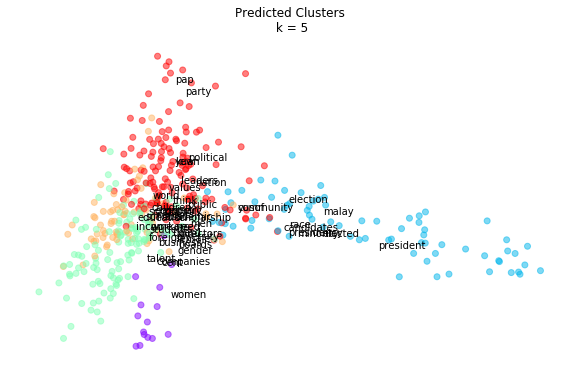

In [12]:
# first, k-means clustering
# intialize tfid vectorizer and transform data into a vector
merit_tfVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
merit_TFVects = merit_tfVectorizer.fit_transform(stbtDF['text'])

# intialize cluster finder, using 5 as default
meritkm = sklearn.cluster.KMeans(n_clusters = 5, init = 'k-means++')

# calculate clusters
meritkm.fit(merit_TFVects)

# print the top 10 words for each cluster
meritterms = merit_tfVectorizer.get_feature_names()
print("Top terms per cluster:")
meritorder_centroids = meritkm.cluster_centers_.argsort()[:, ::-1]
for i in range(5):
    print("Cluster %d:" % i)
    for ind in meritorder_centroids[i, :10]:
        print(' %s' % meritterms[ind])
    print('\n')

# apply PCA
PCA = sklearn.decomposition.PCA
meritpca = PCA(n_components = 2).fit(merit_TFVects.toarray())
merit_reduced = meritpca.transform(merit_TFVects.toarray())

meritcomponents = meritpca.components_
meritkeyword_ids = list(set(meritorder_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
meritwords = [meritterms[i] for i in meritkeyword_ids]#Turn the ids into words.
x = meritcomponents[:,meritkeyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = meritcomponents[:,meritkeyword_ids][1,:]

#color labels
mcolors = list(plt.cm.rainbow(np.linspace(0,1, 5)))
mcolors_p = [mcolors[l] for l in meritkm.labels_]

#plot
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(merit_reduced[:, 0], merit_reduced[:, 1], color = mcolors_p, alpha = 0.5)
for i, word in enumerate(meritwords):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(5))
plt.show()

In [21]:
# topic modelling
dictionary = gensim.corpora.Dictionary(stbtDF['normalized_sents'].sum())

In [22]:
corpus = [dictionary.doc2bow(text) for text in stbtDF['normalized_sents'].sum()]

In [143]:
# serialize the corpus and load it
gensim.corpora.MmCorpus.serialize('stbt.mm', corpus)
stbtmm = gensim.corpora.MmCorpus('stbt.mm')

stbtlda = gensim.models.ldamodel.LdaModel(corpus=stbtmm, id2word=dictionary, num_topics=10
                                          , alpha='auto', eta='auto')

In [144]:
topicsDict = {}
for topicNum in range(stbtlda.num_topics):
    topicWords = [w for w, p in stbtlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,singapore,lee,singapore,singapore,singapore,switzerland,singapore,election,companies,singapore
1,ceo,singapore,would,world,mr,per,women,government,managing,mr
2,trade,minister,learning,asean,swiss,cent,also,political,services,also
3,brand,mr,business,technology,lee,singapore,business,foreign,singapore,region
4,executive,prime,people,director,social,lee,diversity,singapore,boards,leadership
5,private,said,years,mr,two,yew,skills,workers,credit,said
6,sector,hsien,said,one,also,kuan,regional,education,year,meritocracy
7,one,also,need,business,said,mr,asia,new,eu,us
8,directors,yew,businesses,partner,country,legacy,people,also,caption,prof
9,european,kuan,mr,nation,passing,policy,different,gender,yang,society


In [30]:
stbtDF['normalized_sents'][0]

[['young',
  'people',
  'singapore',
  'aged',
  'higher',
  'risk',
  'mental',
  'problems',
  'older',
  'people',
  'study',
  'found'],
 ['fare',
  'top',
  'three',
  'mental',
  'woes',
  'compared',
  'older',
  'adults',
  'high',
  'expectations',
  'hard',
  'work',
  'hallmarks',
  'success',
  'especially',
  'society',
  'forged',
  'blood',
  'sweat',
  'tears',
  'immigrants'],
 ['one',
  'seven',
  'young',
  'people',
  'pressure',
  'may',
  'much',
  'bear',
  'could',
  'spell',
  'disaster',
  'combination',
  'factors'],
 ['many',
  'fall',
  'prey',
  'mental',
  'illness',
  'age',
  'according',
  'million',
  'singapore',
  'mental',
  'health',
  'study',
  'whose',
  'results',
  'released',
  'late',
  'last',
  'year'],
 ['researchers',
  'expected',
  'group',
  'prime',
  'lives',
  'hardest',
  'hit',
  'research',
  'borne',
  'young',
  'vulnerable',
  'illnesses',
  'depression',
  'obsessive',
  'compulsive',
  'behaviour',
  'alcohol',
  'abuse']

In [31]:
# doc2vec
stbtDF['tokenized_words'] = stbtDF['text'].apply(lambda x: nltk.word_tokenize(x))
stbtDF['normalized_words'] = stbtDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [32]:
# doc2vec
keywords = ['race', 'gender','class']
taggedDocs = []
stbtDF['docID'] = stbtDF.index
for index, row in stbtDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['title'])
    docKeywords.append(row['docID'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
stbtDF['tagged'] = taggedDocs

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  # Remove the CWD from sys.path while we load stuff.


In [43]:
#train d2v model
stbtD2V = gensim.models.doc2vec.Doc2Vec(documents = stbtDF['tagged'], size = 100) #Limiting to 100 dimensions

In [48]:
testa = stbtDF['title'][0]

In [70]:
genderCat = []
classCat = []
raceCat = [] 

for index, row in stbtDF.iterrows():
    egtitle = row['title']
    genderscore = sklearn.metrics.pairwise.cosine_similarity(stbtD2V['gender'].reshape(1,-1), stbtD2V.docvecs[egtitle].reshape(1,-1))
    classscore = sklearn.metrics.pairwise.cosine_similarity(stbtD2V['class'].reshape(1,-1), stbtD2V.docvecs[egtitle].reshape(1,-1))
    racescore = sklearn.metrics.pairwise.cosine_similarity(stbtD2V['race'].reshape(1,-1), stbtD2V.docvecs[egtitle].reshape(1,-1))
    if genderscore[0] > 0.9:
        genderCat += '1'
    else:
        genderCat+= '0'
    if classscore[0] > 0.9:
        classCat += '1'
    else:
        classCat+= '0'
    if racescore[0] > 0.9:
        raceCat += '1'
    else:
        raceCat+= '0'        
stbtDF['gender'] = genderCat
stbtDF['class'] = classCat
stbtDF['race'] = raceCat

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [71]:
stbtDF.head()

,Unnamed: 0,abstr,art_num,author,date,section,source,subj,text,title,url,tokenized_sents,normalized_sents,tagged,docID,tokenized_words,normalized_words,gender,class,race
0,0,"According to the survey of 6,600 people aged 1...",1,"Wee, Lea\n","May 3, 2012\n",Mind Your Body\n,The Straits Times; Singapore\n,Mental disorders; Anxieties; Older people; Ch...,Young people in Singapore aged 18 to 29 are a...,Young & disturbed\n,http://sfx.lib.uchicago.edu/sfx_local?url_ver...,"[[Young, people, in, Singapore, aged, 18, to, ...","[[young, people, singapore, aged, higher, risk...","([young, people, singapore, aged, higher, risk...",0,"[Young, people, in, Singapore, aged, 18, to, 2...","[young, people, singapore, aged, higher, risk,...",1,1,0
1,1,[...]his education was practically self-financ...,2,Wong Kim Hoh\n,"May 13, 2012\n",Think\n,The Straits Times; Singapore\n,NaN,Wong Kim Hoh meets...\nChong Kee Hiong\nWhen ...,"To be a CEO, read martial arts novels: The ...",http://sfx.lib.uchicago.edu/sfx_local?url_ver...,"[[Wong, Kim, Hoh, meets, ..., Chong, Kee, Hion...","[[wong, kim, hoh, meets, chong, kee, hiong, pr...","([wong, kim, hoh, meets, chong, kee, hiong, pr...",1,"[Wong, Kim, Hoh, meets, ..., Chong, Kee, Hiong...","[wong, kim, hoh, meets, chong, kee, hiong, pri...",0,0,0
2,2,The Danes - the only people in occupied Europe...,3,Janadas Devan\n,"May 22, 2012\n",Review\n,The Straits Times; Singapore\n,Immigration policy; Workforce; Aliens\n,"AS EVENTS of the past week have revealed, the...","When in Singapore, act like a S'porean: Int...",http://sfx.lib.uchicago.edu/sfx_local?url_ver...,"[[AS, EVENTS, of, the, past, week, have, revea...","[[events, past, week, revealed, divisions, sin...","([events, past, week, revealed, divisions, sin...",2,"[AS, EVENTS, of, the, past, week, have, reveal...","[events, past, week, revealed, divisions, sing...",0,0,0
3,3,While they agreed on respect for multi-racial ...,4,NaN,"May 22, 2012\n",Prime News\n,The Straits Times; Singapore\n,Elections\n,WE HEARD YOU...\nREADERS have told us that th...,The news in 5 minutes\n,http://sfx.lib.uchicago.edu/sfx_local?url_ver...,"[[WE, HEARD, YOU, ...], [READERS, have, told, ...","[[heard], [readers, told, us, find, quick, wra...","([heard, readers, told, us, find, quick, wrap,...",3,"[WE, HEARD, YOU, ..., READERS, have, told, us,...","[heard, readers, told, us, find, quick, wrap, ...",1,1,0
4,4,Only in that way would people be prepared to c...,5,Wang Gungwu\n,"Jun 23, 2012\n",Saturday Special Report\n,The Straits Times; Singapore\n,Education; Families & family life\n,MERITOCRACY is a valued ideal in most of the ...,Meritocracy's enemies: China's long history...,http://sfx.lib.uchicago.edu/sfx_local?url_ver...,"[[MERITOCRACY, is, a, valued, ideal, in, most,...","[[meritocracy, valued, ideal, modern, world], ...","([meritocracy, valued, ideal, modern, world, n...",4,"[MERITOCRACY, is, a, valued, ideal, in, most, ...","[meritocracy, valued, ideal, modern, world, na...",1,1,0


Documents are now assigned classification types based on the similariity of their document vector to a sector group of word vectors.

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [86]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [193]:
pandas.DataFrame(x)

,0,1,2,3,4,5,6,7
0,2.0,3.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,3.0,3.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,4.0,4.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,3.0,3.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,2.0,2.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,4.0,3.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,2.0,2.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,2.0,2.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,3.0,4.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [87]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [88]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [89]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [90]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

In [164]:
?pyanno.measures.agreement.confusion_matrix

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [92]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [93]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [94]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [95]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [96]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


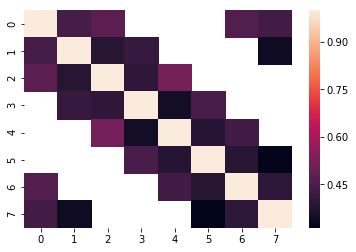

In [97]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [98]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [99]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [100]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

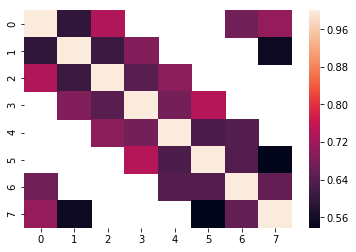

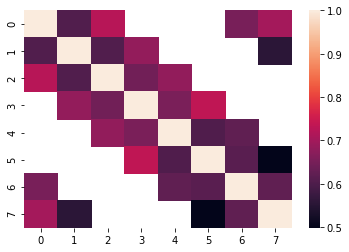

In [101]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [102]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Excercise 2*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides on this week's Canvas page.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [ ]:
# produce a subsample and export it to a csv that's uploadable to MTurk

In [39]:
testDF = pandas.read_csv("meritSTBT.csv")

In [78]:
mturkDF = testDF.iloc[30:31].append(testDF.iloc[120]).append(testDF.iloc[220]).append(testDF.iloc[320]).append(testDF.iloc[420])

In [79]:
mturkDF2 = mturkDF.drop('Unnamed: 0', axis = 1).drop('abstr', axis = 1).drop('subj', axis = 1).drop('url', axis = 1)

In [81]:
mturkDF2.to_csv('xymturk.csv')

In [166]:
mturkDF2

,art_num,author,date,section,source,text,title
30,31,Phua Mei Pin\n,"Oct 19, 2012\n",Singapore\n,The Straits Times; Singapore\n,THE Government is doing both too much and t...,"Govt doing 'too much and too little', say you..."
120,121,"Mokhtar, Maryam\n","Nov 13, 2013\n",Singapore\n,The Straits Times; Singapore\n,THE Parliamentary Secretary for the Ministr...,"Representation by merit, not gender quota\n"
220,221,Bilahari Kausikan\n,"Jun 8, 2015\n",Opinion\n,The Straits Times; Singapore\n,"As Singapore and the region change, foreign...",Foreign policy is no laughing matter\n
320,321,"Nanda, Akshita\n","Mar 11, 2017\n",Life\n,The Straits Times; Singapore\n,"REVIEW / THEATRE\nTHOSE WHO CAN'T, TEACH\nThe...","Perfect for the young, despite its age\n"
420,49,"Shiao, Vivien\n","Mar 11, 2017\n",Life & Culture\n,The Business Times; Singapore\n,"""Now, here, you see, it takes all the running...",It's time women settle for more: The lack o...


In [ ]:
# import results from mturk

In [187]:
resultsDF = pandas.read_csv('mturkresults.csv')
meritDF = resultsDF[['Answer{}'.format(i) for i in range(1, 11)]] + 3

In [188]:
meritMT = meritDF.as_matrix()

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


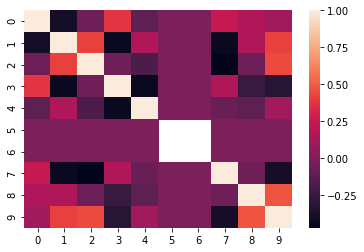

In [194]:
# plot confusion matrix using cohen's kappa
m = pairwise_matrix(cohens_kappa, meritMT)
ax = seaborn.heatmap(m)
plt.show()

In [196]:
# calculate average cohen's kappa
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, meritMT)

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


-0.0116340595249264

This Cohen's Kappa value suggests that there is little to no agreement among my 10 coders ...

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides two relevant models: ModelB and ModelBt. Model B with $\theta$s models the relationship between each coder and code. Model B is a Bayesian generalization of the Dawid & Skene model from the reading. The following image schematically describes these models. <img src="../data/pyanno/Bmodel.png">

The models should provide very similar results. To estimate the parameters for any models, we first need to create a new model. 

In [104]:
# create a new instance of model B, with 4 label classes
model = ModelB.create_initial_state(4,8)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.72683838 0.17984698 0.09017683 0.0031378 ]
  [0.28343397 0.58009959 0.08085798 0.05560845]
  [0.12077629 0.08546724 0.62682769 0.16692878]
  [0.00632361 0.11614535 0.26206398 0.61546706]]

 [[0.62146552 0.20227424 0.16455558 0.01170466]
  [0.10740548 0.63071352 0.21977711 0.04210389]
  [0.14558133 0.07915371 0.48087732 0.29438764]
  [0.13832136 0.11401099 0.11671744 0.63095021]]

 [[0.60406356 0.15575921 0.18288744 0.0572898 ]
  [0.0695427  0.62653082 0.23518792 0.06873856]
  [0.03048207 0.13360677 0.67941107 0.15650009]
  [0.03365525 0.06315541 0.35709045 0.54609889]]

 [[0.72804334 0.18346523 0.07677198 0.01171945]
  [0.22559559 0.40624897 0.24999384 0.1181616 ]
  [0.04218716 0.0880403  0.71730153 0.15247101]
  [0.01423645 0.07561143 0.09506709 0.81508503]]

 [[0.7749588  0.13041554 0.09169118 0.00293448]
  [0.09824599 0.57633753 0.24687379 0.07854269]
  [0.01739458 0.13322091 0.68035639 0.16902813]
  [0.14918061 0.02510377 0.16576948 0.65994615]]

 [[0.71881771 0.08150622 0.108

Now we train the model on our data. Pyanno allows one to use either MAP (maximum a posteriori estimation) or MLE (maximum likelihood estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator-annotation pair. First we will train with MAP, and then you can optionally training with MLE.

In [197]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [198]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.79128793 0.74075211 0.76223851 0.72522522 0.71644338 0.71860563
 0.7732516  0.71665917]
-2811.9463275940407


Uncomment the cell below if you would rather train by MLE.

In [107]:
#model = ModelB.create_initial_state(4,8)
#model.mle(anno.annotations)
#print(model.theta)
#print(model.log_likelihood(anno.annotations))

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [199]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.0111049  0.28931087 0.36497863 0.3346056 ]
 [0.99022365 0.0024189  0.00404901 0.00330844]
 [0.00250012 0.05507729 0.93458995 0.00783264]
 ...
 [0.00252952 0.04396472 0.94558101 0.00792475]
 [0.0024945  0.00571381 0.93249144 0.05930025]
 [0.03189882 0.93881236 0.01611846 0.01317036]]


Let's turn the posterior of the first 100 samples into a heatmap and compare with the raw vote tallies.

In [200]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<matplotlib.figure.Figure at 0x114395a20>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x119964a90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11b3355f8>))

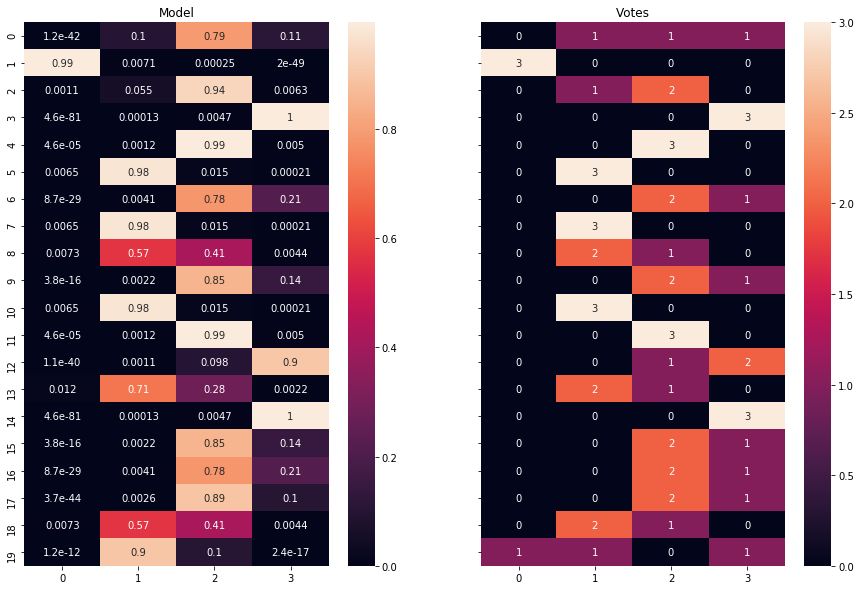

In [110]:
makeQuestionComparison(model, anno)

This differs markedly from taking annotator scores at face value. As you can see (the model-based probabilities are on left; the raw votes on right), the models helps us break ties between coders and in some cases dramatically downgrades the estimates from particularly bad coders.

Let's try everything again with ModelBt, which constrains ModelB so that each coder has a single estimate over the accuracy of all of their codes.

In [111]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.6590319  0.69429247 0.68088304 0.65773348 0.67700793 0.91443911
 0.82360955 0.76530672]
-2921.915197367143


In [112]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.79129645 0.74075063 0.76236848 0.7252117  0.71642799 0.71861344
 0.77323026 0.7166773 ]
-2811.9464818875113


In [113]:
model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

array([[0.79928548, 0.76594749, 0.78135262, ..., 0.70168511, 0.80910394,
        0.74996388],
       [0.79928548, 0.76594749, 0.78135262, ..., 0.70168511, 0.80910394,
        0.74996388],
       [0.79928548, 0.76594749, 0.78135262, ..., 0.70168511, 0.80910394,
        0.74996388],
       ...,
       [0.78056601, 0.74897895, 0.78149894, ..., 0.74492416, 0.74559464,
        0.72436877],
       [0.78056601, 0.74897895, 0.78149894, ..., 0.74492416, 0.74559464,
        0.72436877],
       [0.78056601, 0.74897895, 0.78149894, ..., 0.74492416, 0.74559464,
        0.72436877]])

In [114]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.01110241 0.28921552 0.36492555 0.33475652]
 [0.99023118 0.0024167  0.00404631 0.00330581]
 [0.00249973 0.05509976 0.93456939 0.00783111]
 ...
 [0.00252921 0.04395647 0.94559084 0.00792347]
 [0.00249419 0.00571221 0.93249787 0.05929573]
 [0.03190494 0.9388024  0.01612151 0.01317116]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

(<matplotlib.figure.Figure at 0x11989f748>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11b1db128>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11b5e29e8>))

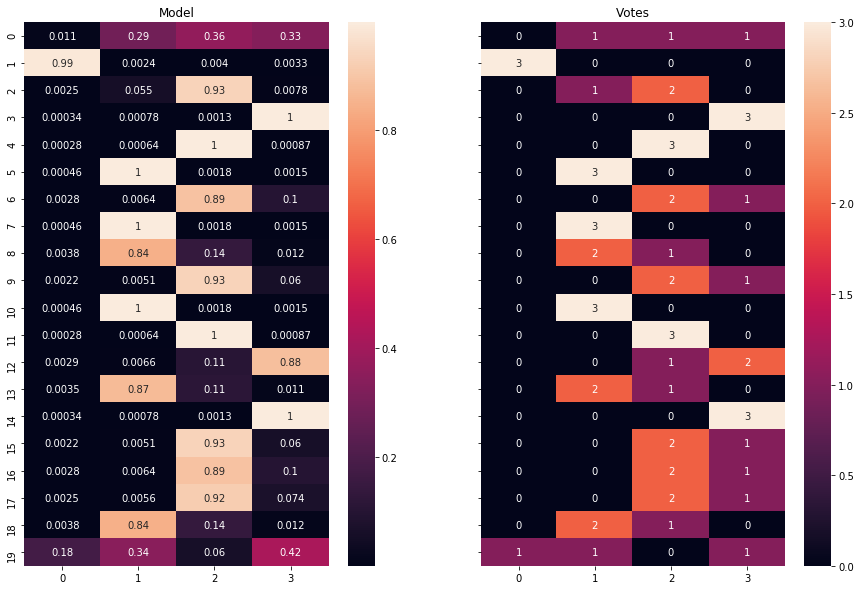

In [115]:
makeQuestionComparison(model, anno)

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. We may also use the posterior themselves rather than the most probably code outcome.

## Visualizing coder accuracy

Let's make a plot of the accuracy for each annotator inferred from ModelBt. This might be helpful if you wanted to ban a "troll" from your crowdsourcing enterprise. The coder a very low accuracy likelihood is an outlier and should be "dropped from the team."

In [201]:
model = ModelBt.create_initial_state(4,8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

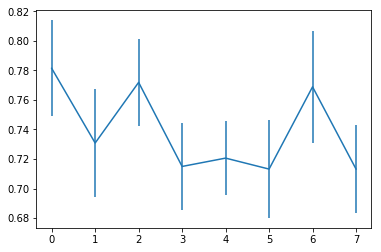

In [202]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Hotel Reviews

If we want to do a simpler analysis we can look at a different data set, here are some hotel reviews from [expedia](https://www.kaggle.com/c/expedia-hotel-recommendations)

In [203]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

,Karen,Scott,Jessica,write a review,A verified traveler,Kevin,William,R,S,Christopher,...,Thomas,Susan,A Traveler,M,Not Provided,B,Laura,xxxxxxxxxxxxxx,Michael,Joseph
1785 Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900 House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bed & Breakfast In Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Swallow's Nest Motel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abbeville Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [204]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values

And we can visualize all the reviews as a heatmap with the missing values greyed out

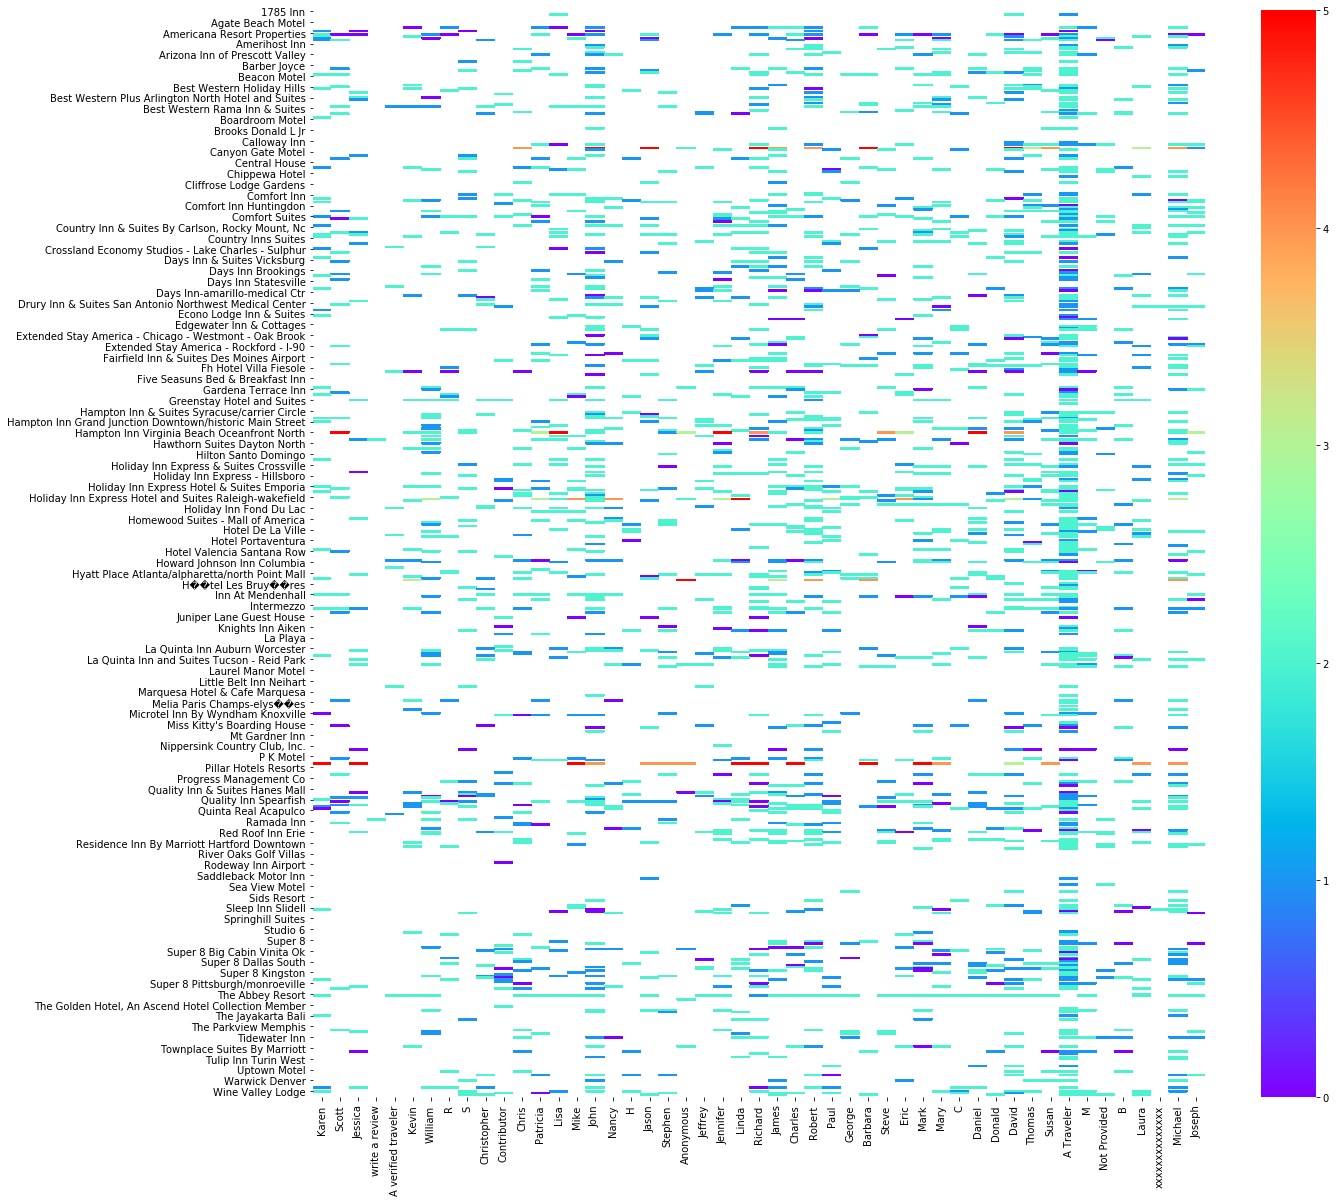

In [205]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [206]:
hot_mat = np.array(df_hotels.fillna(-1).as_matrix())
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [207]:
anno_hot.annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [208]:
anno_hot.labels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [209]:
anno_hot.missing_values

[-1]

Look at coder agreement

In [210]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

array([0.07806534, 0.26262198, 0.63555367, 0.00636402, 0.0093339 ,
       0.00806109])

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


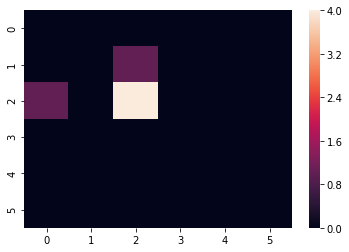

In [211]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [212]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.3787878787878787

In [213]:
krippendorffs_alpha(anno_hot.annotations[::])

0.398760907615921

In [214]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.40328336902212697

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


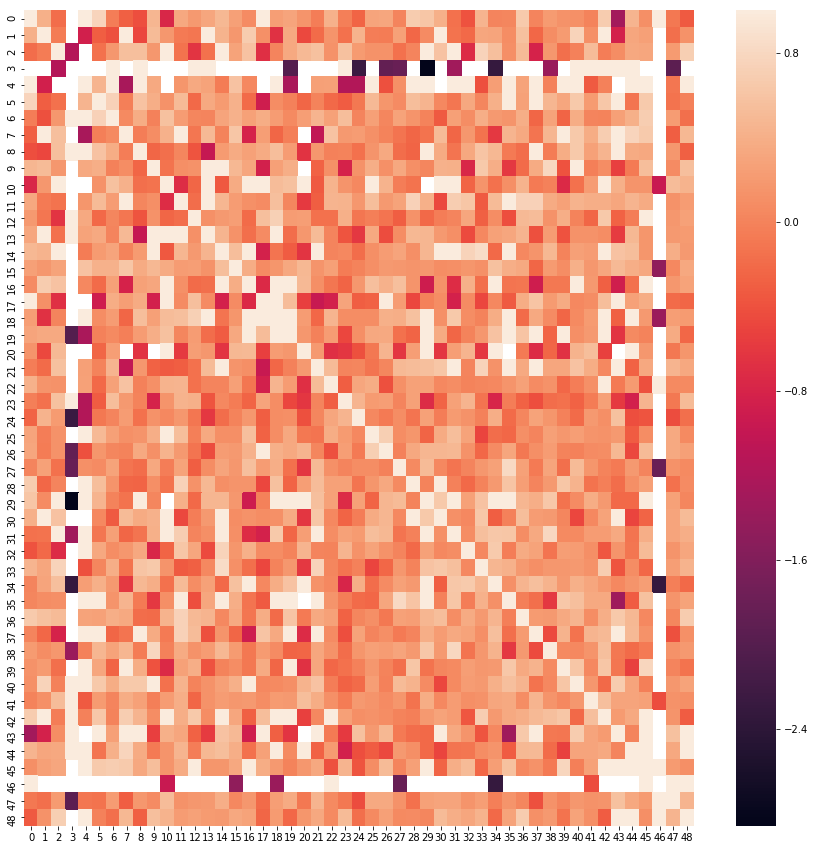

In [215]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

And to look at what model Bt thinkgs the correct reviews are:

In [216]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
#print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

-2709.006691533543


(<matplotlib.figure.Figure at 0x11b987160>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11e2c02b0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11e3dd550>))

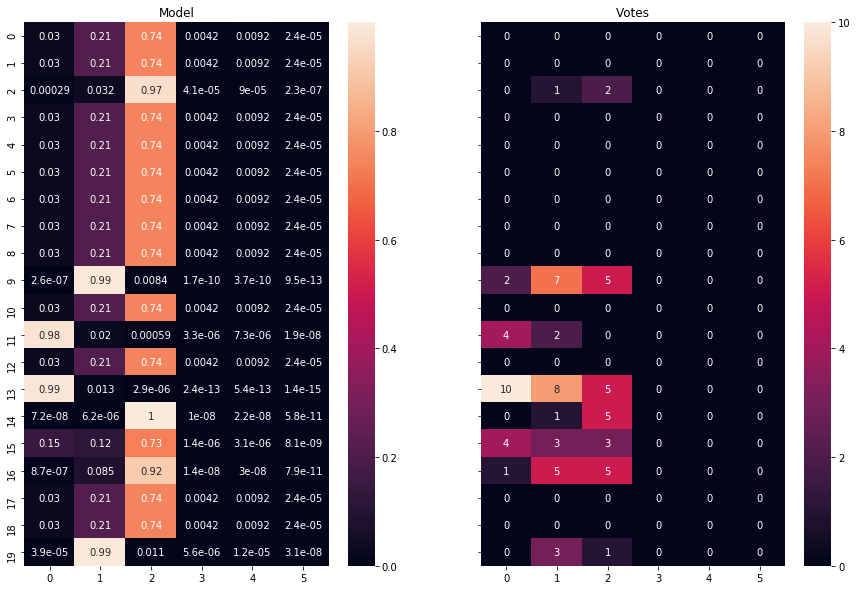

In [217]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MLE or MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

In [253]:
manno = AnnotationsContainer.from_array(meritMT)

In [255]:
model = ModelBt.create_initial_state(5,10)
model.mle(manno.annotations)
samples = model.sample_posterior_over_accuracy(manno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

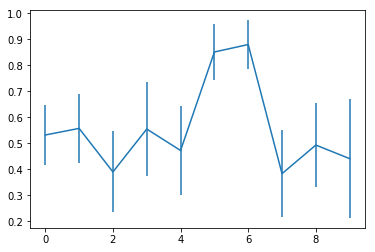

In [256]:
plt.figure()
plt.errorbar(range(10),y, yerr = y_ci)
plt.show()

It appears that a majority of my coders are low-skilled? Why is this the case?? It's bizzare: the "best" rated are the ones who just rated most of the sample "3" (which corresponds to neutral on my likert scale). As shown below:

In [257]:
meritDF

,Answer1,Answer2,Answer3,Answer4,Answer5,Answer6,Answer7,Answer8,Answer9,Answer10
0,3,4,4,3,3,3,3,5,4,4
1,4,3,5,4,3,3,3,4,3,3
2,3,4,4,3,4,3,3,3,3,4
3,2,4,2,3,4,3,3,4,5,2
4,2,3,3,3,4,3,3,4,2,2


(<matplotlib.figure.Figure at 0x11dec0e48>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11df5bda0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11db71898>))

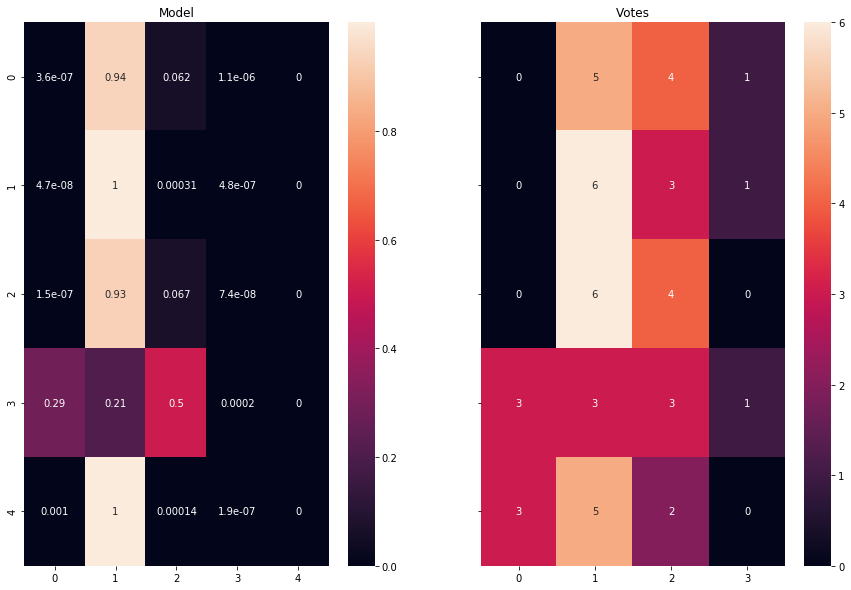

In [246]:
#something is off about this, but I wasn't able to figure it out yet.
makeQuestionComparison(model, manno, num_questions= 10)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 2.]
 [0. 0. 0. 1. 0.]]


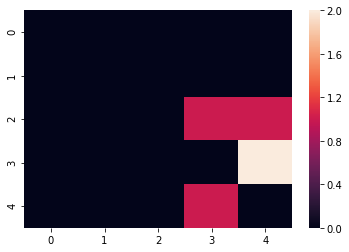

In [227]:
c = pyanno.measures.agreement.confusion_matrix(meritMT[:,0], meritMT[:,1], 5) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()